<a href="https://colab.research.google.com/github/songqsh/foo1/blob/master/src/value_iter_dirichlet_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time
start_time = time.time()

from tqdm import tqdm
import matplotlib.pyplot as plt

__Goal__

Implement value iteration on 1d HJB with Dirichlet data and verify with the explicit solution on Whittle’s “Flypaper”

__Ref__

- [1] Chap V.7 of [Roger and Williams 2000] 

- [2] P97, Example 4 of [Kushner and Dupuis 2001]


__Problem setup__

We want to solve HJB
$$\inf_a \{b(x,a) v'(x) + \frac 1 2 \sigma^2 v''(x) - \lambda v(x) + \ell(x,a)\} = 0, \quad \hbox{ on } O = (l, u)$$
with Dirichlet data
$$v(x) = g(x), \quad x= l, u.$$

It's equivalent to the following stochastic control formulation in a broad sense. Given a controlled diffusion
$$d X_t = b(X_t, a_t) dt + \sigma dW_t$$
we seek for the value function
$$v(x) = \inf_{a(\cdot)} \mathbb E^x [e^{-\lambda s} \ell(X_s, a_s) ds + e^{-\lambda \tau} g(X_\tau)],$$
where $\tau$ is
$$\tau = \inf\{t>0: X_t \notin O\}.$$


__MDP discretization__

One can use central finite difference scheme with parameter $h$ to obtain the following MDP. 

- Let $X^h$ be a controlled Markov chain on its state space 
$$\mathbb  R^h = \{h i: i\in \mathbb Z\}.$$

- transition probability is, with sufficiently small $h>0$, 
$$p^h(x+h|x, a) = \frac{b(x,a) + \sigma^2}{2\sigma^2}$$
and
$$p^h(x+h|x, a) = \frac{-b(x,a) + \sigma^2}{2\sigma^2}.$$

- terminal time is
$$\tau^h = \inf\{t>0: X^h \notin O \}.$$

- value function is
$$v^h(x) = \inf_{a^h} \mathbb E^x \Big[ 
\sum_{t=0}^{\tau^h-1} \Lambda^{-t} \ell^h(X^h_t, a^h_t) + 
\Lambda^{-\tau^h} g(X_{\tau^h})
\Big],$$
where
$$
\Lambda = 1 + \lambda \frac{h^2}{\sigma^2}.
$$

__Rk__

There is essential difference of above MDP approximation using central FDM from the one
using upward FDM provided by P97 of [2].

__benchmark__


We will recall a simple stochastic control problem, so called 
Whittle's ``flypaper'' given in [1]. This is a homogenous 
stochastic exit problem, which can be explicitly solved out.


Let parameters be given by

- $O = (0, z)$

- $\sigma = 1$

- $b(x,a) = a$

- $\lambda = 0$

- $\ell(x,a) = \frac 1 2 (a^2+1)$

- $g(x) = - \ln (c_1 e^x + c_2 e^{-x}).$

The value function is 
$$v(x) = g(x)$$
and the optimal policy is
$$a^*(x) = - g'(x).$$

__Ex__ In the above Whittle's "flypaper", answer the following questions:

- show that $v$ is concave.
- show that the optimal policy $|a^*(x)|\le 1$.
- solve for the exact solution for terminal cost given by
$$g(x) = x^2.$$

In [0]:
#configure
C1 = 1
C2 = 1

U_LIM = 1 #upper limit for state
L_LIM = 0 #lower limit for state

TOL = 0.001 #tolerance for iteration
MAX_ITER = 1000 #maximum iteration

In [0]:
#start MDP approximation
#configure

NUM = 5 #num of meshes in one unit state space

In [0]:
#configure

lambda_ = 0. #discount rate
sigma = 1. #diffusion coefficient
drift = lambda x,a: a #drift coefficient

run_cost = lambda x, a: (a**2+1)/2.
term_cost = lambda x: - np.log(C1*np.exp(x) + C2*np.exp(-x))



In [0]:
h = 1./NUM #mesh size in state space

s_space = np.arange(L_LIM, U_LIM+h, h) #state space

a_space = np.arange(2*L_LIM, 2*U_LIM + h, h) #action space

del_ind_space = np.array([-1,1]) #space of delta (1-step) index: -1 means left, 1 means right move

term_ind_space = np.array([0, s_space.size-1]) #space of terminal state indice


In [0]:
#transition probability
#output is probability (np array) on del_ind_space

def transition_probability(x, a):
  tp = np.zeros(del_ind_space.shape)
  
  b_ = drift(x,a)
  tp[0] = (-b_*h + sigma**2)/(2*sigma**2)
  tp[1] = (b_*h + sigma**2)/(2*sigma**2)
  
  #correction on prob
  if tp[1]<0:
    tp = tp - tp[1]
    tp = tp/tp.sum()
    print('>>>>corrected')

  return tp

In [7]:
#q-table and state value initialization

s_val = np.zeros(s_space.size)
q_table = np.zeros([s_space.size, a_space.size])

'''
#adjust start
for i in range(s_space.size):
  q_table[i] = term_cost(s_space[i])*np.ones(a_space.size)
'''

print('>>>>> q_table size is %i' %(q_table.size))

>>>>> q_table size is 66


In [0]:
#q-table terminal setup
for i in term_ind_space:
  for j in range(a_space.size):
    q_table[i,j] = term_cost(s_space[i])

In [0]:
#sync q_table, s_val
def q_s_sync(ind):
  s_val[ind] = np.min(q_table[ind])
  
q_s_sync(0)
q_s_sync(s_val.size-1)

In [10]:
#value iteration

eps = 1.
iter = 0
while eps>TOL and iter < MAX_ITER:
  pre_s_val = s_val.copy()
  #import pdb; pdb.set_trace()
  for i in range(1, s_space.size -1):
    for k in range(a_space.size):
      x_ = s_space[i]
      a_ = a_space[k]
      tp_ = transition_probability(x_,a_)
      run_cost_ = run_cost(x_,a_)*h**2/sigma**2
      Lambda_ = 1 + lambda_*h**2/sigma**2
      
      q_table[i,k] = (run_cost_ + tp_[0]*s_val[i-1] + tp_[1]*s_val[i+1])/Lambda_
      
    q_s_sync(i)
    
  
  eps = np.max(np.abs(pre_s_val - s_val))
  #import pdb; pdb.set_trace()
  iter += 1
  if np.mod(iter,10) == 0:
    print('iterated ' + str(iter)+';')

iterated 10;


In [11]:
exact_val = term_cost(s_space) #exact value for performance compare
end_time = time.time()
print('elapsed time is %f seconds' %(end_time - start_time))

elapsed time is 0.149739 seconds


>>>epsilon is 0.0006691019413483934
>>>iter number is 15
>>>max norm of error is 0.002093589827348974


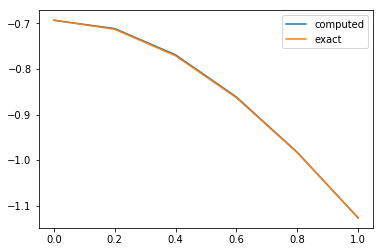

In [12]:
plt.plot(s_space, s_val, label = 'computed')
plt.plot(s_space, exact_val, label = 'exact')
plt.legend()
print('>>>epsilon is ' + str(eps))
print('>>>iter number is ' + str(iter))
print('>>>max norm of error is ' + str(np.max(np.abs(s_val-exact_val))))